# Segunda práctica de Aprendizaje Automático

Implementación del grupo 17, formado por:
- Sergio Barragán Blanco (100472343)
- Eduardo Alarcón Navarro (100472175)

# Lectura del fichero CSV


In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carga de datos
data = pd.read_csv('Stars2.csv')


# A continuación, haremos nuestra propia implementación del Kmeans

In [58]:

class Kmeans():
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = 343175
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X, y=None, sample_weight=None):
        # Inicialización de los centroides de manera aleatoria
        rng = np.random.default_rng(self.random_state)
        self.cluster_centers_ = rng.choice(X, size=self.n_clusters, replace=False)

        for _ in range(self.max_iter):
            self._assign_labels(X)

            new_centers = self._compute_centers(X, self.labels_)

            if np.allclose(self.cluster_centers_, new_centers, atol=self.tol):
                break
            
            self.cluster_centers_ = new_centers

    def _assign_labels(self, X):
        labels = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            # Calcular la distancia euclidiana a cada centroide
            distances = np.linalg.norm(self.cluster_centers_ - x, axis=1)
            # Asignar el punto al clúster con la distancia más corta
            labels[i] = np.argmin(distances)
        self.labels_ = labels

    def _compute_centers(self, X, labels):
        new_centers = np.empty_like(self.cluster_centers_)
        for i in range(self.n_clusters):
            # Calcular el nuevo centroide como el promedio de los puntos asignados al clúster i
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = np.mean(cluster_points, axis=0)
            else:
                # Si no hay puntos asignados al clúster, mantener el centroide actual
                new_centers[i] = self.cluster_centers_[i]
        return new_centers


# A continuación, haremos el encoding de los datos, podemos hacer tanto OneHot como Ordinal

In [76]:
# Mapeo de los valores de los colores
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Codificación ordinal de los colores
color_encoder = OrdinalEncoder(categories=[normalized_colors])
color_encoded = color_encoder.fit_transform(data[['Color']])

# Codificación ordinal de la clase espectral
spectral_encoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])
spectral_class_encoded = spectral_encoder.fit_transform(data[['Spectral_Class']])

data['Color'] = color_encoded
data['Spectral_Class'] = spectral_class_encoded



# Escalado de características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Clustering con KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_pca)

# Predicciones de cluster
cluster_labels = kmeans.predict(data_pca)

ValueError: could not convert string to float: 'Red'

Ahora lo mostraremos en una tabla

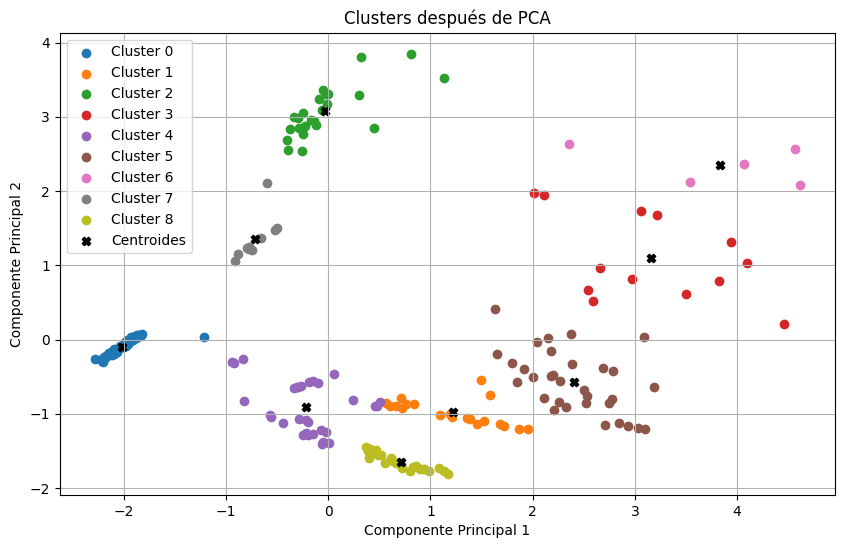

In [68]:
# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels):
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters después de PCA')
plt.legend()
plt.grid(True)
plt.show()

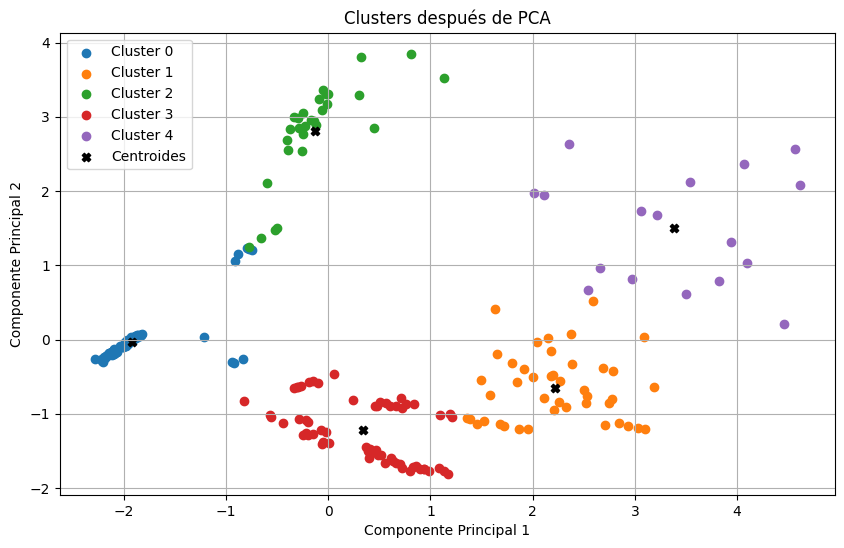

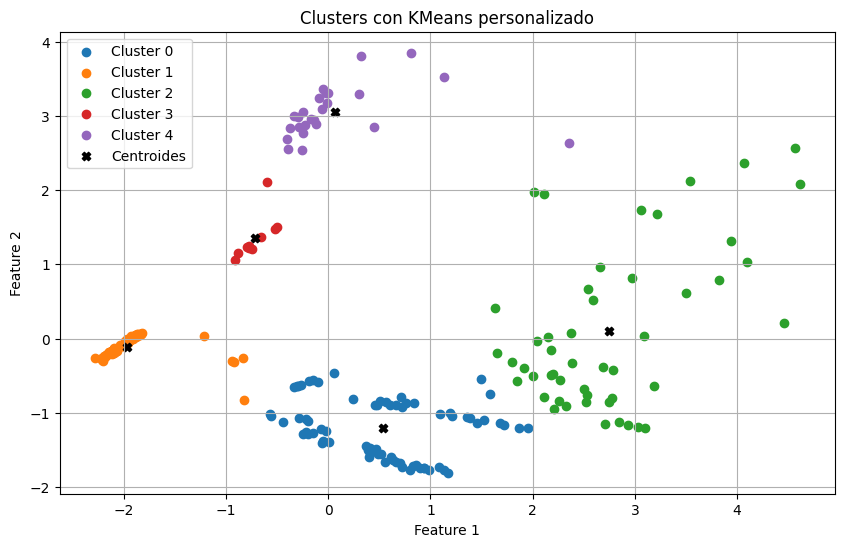

In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carga de datos
data = pd.read_csv('Stars2.csv')

# Mapeo de los valores de los colores
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Codificación ordinal de los colores
color_encoder = OrdinalEncoder(categories=[normalized_colors])
data['Color_Encoded'] = color_encoder.fit_transform(data[['Color']])

# Codificación ordinal de la clase espectral
spectral_encoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])
data['Spectral_Class_Encoded'] = spectral_encoder.fit_transform(data[['Spectral_Class']])

# Eliminamos las columnas originales de color y clase espectral
data.drop(['Color', 'Spectral_Class'], axis=1, inplace=True)

# Escalado de características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Clustering con KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_pca)

# Predicciones de cluster
cluster_labels = kmeans.predict(data_pca)

# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels):
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters después de PCA')
plt.legend()
plt.grid(True)
plt.show()

# Y ploteamos nuestro gráfico

kmeans = Kmeans(n_clusters=5)
kmeans.fit(data_pca)

# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(kmeans.labels_):
    plt.scatter(data_pca[kmeans.labels_ == label, 0], data_pca[kmeans.labels_ == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters con KMeans personalizado')
plt.legend()
plt.grid(True)
plt.show()


